In [1]:
import pandas as pd
import numpy as np
import seaborn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

In [3]:
raw_file = pd.read_csv("data/overall_stats_salary.csv")
raw_file

,season,seas_id,player_id,player,birth_year,pos,age,tm,experience,g,...,ts_percent_y,e_fg_percent,tov_percent_y,orb_percent_y,ft_fga,opp_e_fg_percent,opp_tov_percent,opp_drb_percent,opp_ft_fga,salary
0,1990,11801,2218,A.C. Green,NaN,PF,26,LAL,5,82,...,0.562,0.512,13.2,32.8,0.271,0.479,12.8,68.5,0.219,4110398.0
1,1990,11803,2479,Adrian Caldwell,NaN,PF,23,HOU,1,51,...,0.531,0.491,15.5,33.1,0.225,0.475,14.7,69.2,0.228,645919.0
2,1990,11804,1692,Adrian Dantley,NaN,SF,34,DAL,14,45,...,0.536,0.487,13.6,30.3,0.254,0.481,13.4,67.9,0.232,939519.0
3,1990,11805,1693,Alex English,NaN,SF,36,DEN,14,80,...,0.523,0.478,11.2,29.1,0.217,0.501,15.2,71.3,0.264,3523198.0
4,1990,11806,2480,Alexander Volkov,NaN,C,25,ATL,1,72,...,0.547,0.496,13.5,36.3,0.277,0.509,14.0,65.5,0.254,1526719.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15636,2023,31131,4580,Zach Collins,NaN,C,25,SAS,5,63,...,0.554,0.525,13.0,25.6,0.170,0.576,12.0,74.9,0.201,7700000.0
15637,2023,31132,4299,Zach LaVine,NaN,SG,27,CHI,9,77,...,0.587,0.550,12.2,20.1,0.203,0.544,13.5,77.8,0.197,40064220.0
15638,2023,31133,4898,Zeke Nnaji,NaN,PF,22,DEN,3,53,...,0.601,0.573,13.1,24.8,0.194,0.543,12.2,76.4,0.201,4306281.0
15639,2023,31134,5024,Ziaire Williams,NaN,SF,21,MEM,2,37,...,0.570,0.540,11.7,26.5,0.190,0.526,13.1,75.9,0.206,4810200.0


Fix players that player that play multiple position

<Axes: title={'center': 'Player distribution by position'}>

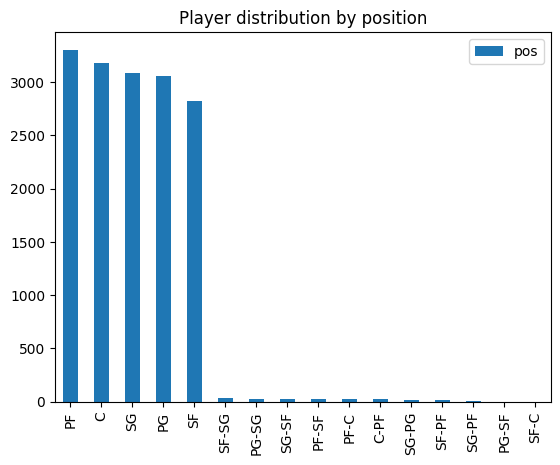

In [4]:
pd.DataFrame(raw_file["pos"].value_counts()).plot.bar(title = "Player distribution by position")

In [5]:
# Pick position that the player plays max
max_pos = raw_file[['pg_percent', 'sg_percent','sf_percent', 'pf_percent','c_percent']].idxmax(axis=1).str.split("_", expand = True).iloc[:,0].str.upper()
raw_file["pos"] = np.where(raw_file["pos"].str.len() > 2, max_pos, raw_file["pos"])
raw_file["pos"].value_counts()

PF    3345
C     3205
SG    3128
PG    3088
SF    2865
Name: pos, dtype: int64

# Data Cleansing

In [6]:
columns_nas = pd.DataFrame(raw_file.isna().sum().sort_values(ascending=False)).head(15)
columns_nas

,0
birth_year,15451
nba roy_share,15425
nba roy_winner,15425
All-Rookie,15308
All-Defense,15308
smoy_share,15213
smoy_winner,15213
All-NBA,15149
dpoy_winner,15142
dpoy_share,15142


In [7]:
# Drop useless columns at the moment
useless = ["birth_year", "tm", "player", "season", "seas_id", "player_id"]
raw_file = raw_file.drop(columns = useless)

# Feature Engineering - on Awards

In [8]:
# Awards + Position
to_binary = ["nba roy_winner", "smoy_winner", "dpoy_winner", "nba mvp_winner", "mip_winner"]
to_multiple_binary = ["All-Rookie", "All-Defense", "All-NBA", "pos"]
drop = ["nba roy_share", "smoy_share", "dpoy_share", "mip_share"]
keep_and_fill_0 = ["nba mvp_share"]

In [9]:
to_multiple_binary_df = pd.get_dummies(raw_file[to_multiple_binary], dtype=float)
to_multiple_binary_df

,All-Rookie_1st,All-Rookie_2nd,All-Defense_1st,All-Defense_2nd,All-NBA_1st,All-NBA_2nd,All-NBA_3rd,pos_C,pos_PF,pos_PG,pos_SF,pos_SG
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
for col in to_binary:
    raw_file[col] = raw_file[col].fillna(0).astype(int)

raw_file = pd.concat([raw_file.drop(columns = to_multiple_binary + drop), to_multiple_binary_df], axis=1)
for col in keep_and_fill_0:
    raw_file[col] = raw_file[col].fillna(0)

Feature Cleansing - Temporary drop Stats NA before 1996


In [11]:
missing_col_before_1996 = pd.DataFrame(raw_file.isna().sum())
missing_col_before_1996 = missing_col_before_1996[missing_col_before_1996 == 2533].dropna().index.tolist()
raw_file = raw_file.drop(columns = missing_col_before_1996)

In [12]:
numerical_features = raw_file.select_dtypes(exclude = ["object"]).columns
numerical_features = list(numerical_features.drop("salary"))


Feature Cleansing - Other Columns missing data

In [13]:
fill_with_mean_median = ["f_tr_y", "d_rtg_y", "ft_fga", "orb_percent_y", "tov_percent_y", "e_fg_percent", "ts_percent_y", "x3p_ar_y",
                  "pace", "n_rtg", "o_rtg_y", "opp_drb_percent", "srs", "sos", "mov", "pl", "pw", "l", "w", "opp_tov_percent", "opp_e_fg_percent",
                  "opp_ft_fga", "x3p_ar_x", "f_tr_x", "ts_percent_x", "tov_percent_x"]
fill_false = ["playoffs"]

<Axes: title={'center': 'Histrogram: Pace'}, ylabel='Frequency'>

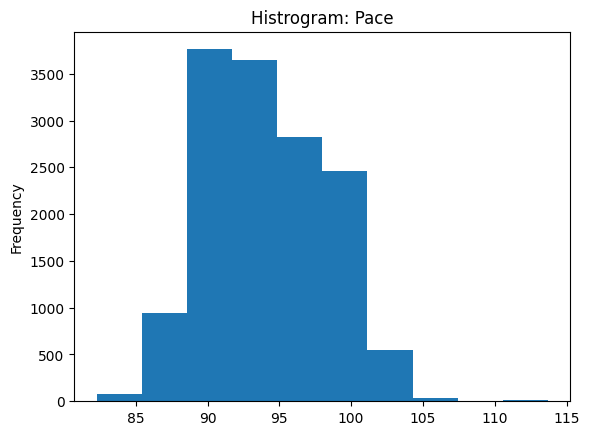

In [14]:
raw_file["pace"].plot.hist(title = "Histrogram: Pace")

<Axes: title={'center': 'Histrogram: f_tr_x'}, ylabel='Frequency'>

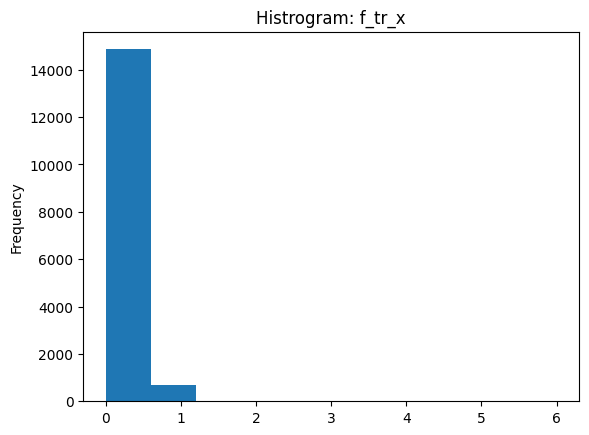

In [15]:
raw_file['f_tr_x'].plot.hist(title = "Histrogram: f_tr_x")

In [16]:
fill_with_mean, fill_with_median = [], []
for col in fill_with_mean_median:
    # Fill with median if large skewness, otherwise fill with mean
    if abs(raw_file[col].skew()) >= 1:
        fill_with_median.append(col)
        raw_file[col] = raw_file[col].fillna(raw_file[col].median())
    else:
        fill_with_mean.append(col)
        raw_file[col] = raw_file[col].fillna(raw_file[col].mean())

for col in fill_false:
    raw_file[col] = raw_file[col].fillna(False).astype(int)

In [17]:
fill_with_median

['f_tr_x', 'ts_percent_x', 'tov_percent_x']

In [18]:
len(fill_with_mean), len(fill_with_median)

(23, 3)

Drop few rows with empty values

In [19]:
print("Before", raw_file.shape)
raw_file = raw_file.dropna()
print("After", raw_file.shape)

Before (15641, 115)
After (15640, 115)


In [20]:
pd.options.display.max_columns=111
raw_file.head()

,age,experience,g,mp,per,ts_percent_x,x3p_ar_x,f_tr_x,orb_percent_x,drb_percent,trb_percent,ast_percent,stl_percent,blk_percent,tov_percent_x,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp,All Star?,share,x1st_tm,x2nd_tm,x3rd_tm,fg_per_36_min,fga_per_36_min,fg_percent_x,x3p_per_36_min,x3pa_per_36_min,x3p_percent_x,x2p_per_36_min,x2pa_per_36_min,x2p_percent_x,ft_per_36_min,fta_per_36_min,ft_percent_x,orb_per_36_min,drb_per_36_min,trb_per_36_min,ast_per_36_min,stl_per_36_min,blk_per_36_min,tov_per_36_min,pf_per_36_min,pts_per_36_min,fg_per_100_poss,fga_per_100_poss,fg_percent_y,x3p_per_100_poss,x3pa_per_100_poss,...,fta_per_100_poss,ft_percent_y,orb_per_100_poss,drb_per_100_poss,trb_per_100_poss,ast_per_100_poss,stl_per_100_poss,blk_per_100_poss,tov_per_100_poss,pf_per_100_poss,pts_per_100_poss,o_rtg_x,d_rtg_x,dpoy_winner,mip_winner,nba mvp_share,nba mvp_winner,nba roy_winner,smoy_winner,playoffs,w,l,pw,pl,mov,sos,srs,o_rtg_y,d_rtg_y,n_rtg,pace,f_tr_y,x3p_ar_y,ts_percent_y,e_fg_percent,tov_percent_y,orb_percent_y,ft_fga,opp_e_fg_percent,opp_tov_percent,opp_drb_percent,opp_ft_fga,salary,All-Rookie_1st,All-Rookie_2nd,All-Defense_1st,All-Defense_2nd,All-NBA_1st,All-NBA_2nd,All-NBA_3rd,pos_C,pos_PF,pos_PG,pos_SF,pos_SG
0,26,5,82,2709,14.7,0.548,0.057,0.459,11.5,18.4,15.1,4.6,1.2,1.1,10.7,17.1,4.4,3.3,7.7,0.137,0.3,-0.9,-0.6,1.0,1.0,0.0,0,0,0,5.1,10.7,0.478,0.2,0.6,0.283,4.9,10.1,0.489,3.7,4.9,0.751,3.5,6.0,9.5,1.2,0.9,0.7,1.5,2.8,14.1,7.1,14.8,0.478,0.2,0.8,...,6.8,0.751,4.8,8.3,13.1,1.7,1.2,0.9,2.1,3.8,19.5,116,107,0,0,0.0,0,0,0,1,63.0,19.0,58.0,24.0,6.78,-0.04,6.74,114.0,107.0,7.0,96.3,0.345,0.120,0.562,0.512,13.2,32.8,0.271,0.479,12.8,68.5,0.219,4110398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,23,1,51,331,9.5,0.549,0.000,0.368,11.7,22.9,17.4,2.8,1.6,3.2,26.6,14.8,-0.3,0.7,0.4,0.061,-5.3,1.4,-4.0,-0.2,0.0,0.0,0,0,0,4.6,8.3,0.553,0.0,0.0,0.000,4.6,8.3,0.553,1.4,3.0,0.464,3.9,7.9,11.9,0.8,1.2,2.0,3.5,7.5,10.5,6.0,10.9,0.553,0.0,0.0,...,4.0,0.464,5.2,10.5,15.6,1.0,1.6,2.6,4.6,9.9,13.9,91,100,0,0,0.0,0,0,0,1,41.0,41.0,45.0,37.0,1.46,0.24,1.71,104.8,103.4,1.4,101.2,0.313,0.068,0.531,0.491,15.5,33.1,0.225,0.475,14.7,69.2,0.228,645919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,34,14,45,1300,15.4,0.556,0.004,0.525,6.9,8.1,7.5,9.6,0.8,0.3,11.2,22.6,2.2,0.8,3.1,0.113,0.9,-1.4,-0.4,0.5,0.0,0.0,0,0,0,6.4,13.4,0.477,0.0,0.1,0.000,6.4,13.3,0.479,5.5,7.0,0.787,2.2,2.6,4.8,2.2,0.6,0.2,2.1,2.7,18.3,9.0,18.9,0.477,0.0,0.1,...,9.9,0.787,3.0,3.7,6.7,3.1,0.8,0.3,2.9,3.9,25.9,113,112,0,0,0.0,0,0,0,1,47.0,35.0,41.0,41.0,0.07,0.35,0.42,107.2,107.2,0.0,94.5,0.331,0.071,0.536,0.487,13.6,30.3,0.254,0.481,13.4,67.9,0.232,939519.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,36,14,80,2211,17.9,0.522,0.004,0.142,5.3,8.4,6.8,15.6,1.1,0.6,6.3,26.0,3.3,1.7,5.1,0.110,2.5,-1.2,1.2,1.8,0.0,0.0,0,0,0,10.3,21.1,0.491,0.0,0.1,0.400,10.3,21.0,0.491,2.6,3.0,0.880,1.9,2.7,4.7,3.7,0.8,0.4,1.5,2.1,23.3,13.1,26.6,0.491,0.0,0.1,...,3.8,0.880,2.5,3.4,5.9,4.6,1.1,0.5,1.9,2.7,29.5,110,110,0,0,0.0,0,0,0,1,43.0,39.0,45.0,37.0,1.41,0.15,1.56,108.0,106.7,1.3,105.4,0.275,0.084,0.523,0.478,11.2,29.1,0.217,0.501,15.2,71.3,0.264,3523198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25,1,72,937,11.9,0.530,0.120,0.423,6.2,8.5,7.3,12.3,1.9,1.4,13.4,17.4,1.0,0.4,1.4,0.074,-1.3,0.1,-1.2,0.2,0.0,0.0,0,0,0,5.3,10.9,0.482,0.5,1.3,0.382,4.8,9.6,0.496,2.7,4.6,0.583,2.0,2.6,4.6,3.2,1.4,0.8,2.0,6.4,13.7,7.3,15.2,0.482,0.7,1.8,...,6.4,0.583,2.8,3.6,6.4,4.4,1.9,1.2,2.8,8.9,19.1,110,113,0,0,0.0,0,0,0,0,41.0,41.0,44.0,38.0,1.02,-0.39,0.64,113.0,111.9,1.1,95.8,0.362,0.059,0.547,0.496,13.5,36.3,0.277,0.509,14.0,65.5,0.254,1526719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Y: Salary is highly skewed => transform that

2.191767147772739
5.658145814554576


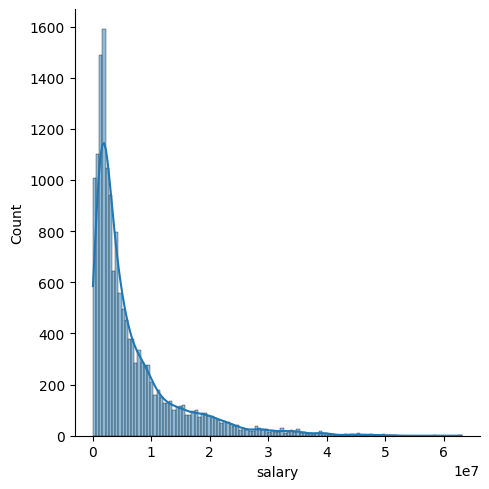

In [21]:
seaborn.displot(raw_file, x="salary", kde=True)
print(raw_file["salary"].skew())
print(raw_file["salary"].kurtosis())


In [22]:
raw_file["salary"] = np.log(raw_file["salary"])

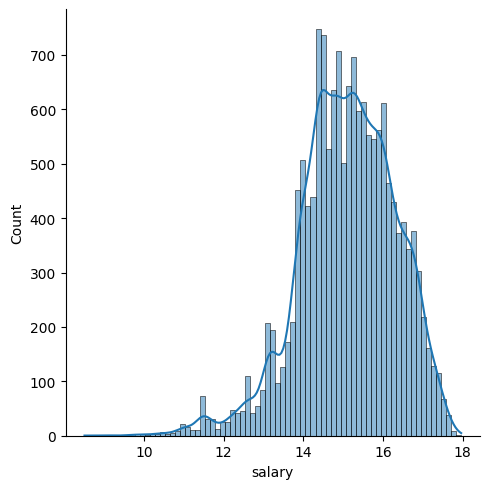

In [23]:
seaborn.displot(raw_file, x="salary", kde=True)

In [24]:
raw_file["salary"].head(15)

0     15.229030
1     13.378429
2     13.753123
3     15.074880
4     14.238632
5     15.200043
6     14.530153
7     12.462136
8     12.462136
9     12.462136
10    14.158589
11    14.175118
12    14.175118
13    14.175118
14    14.851736
Name: salary, dtype: float64

Data Modelling

In [25]:
X = raw_file.drop(columns = ["salary"])
Y = raw_file["salary"]
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.3, random_state=0)

In [67]:
print(len(X), len(Y), len(X_train), len(X_valid), len(Y_train), len(Y_valid))

15640 15640 10948 4692 10948 4692


In [26]:
evaluation = {}
evaluation_kfold = {}
evaluation_kfold_all = {}

# Model 1: Simple Linear Regression

In [27]:
model = LinearRegression().fit(X_train, Y_train)
pred = model.predict(X_valid)

In [28]:
evaluation["Simple Linear Regression"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["Simple Linear Regression"])

[0.846048623546224, 0.5061678043052642]


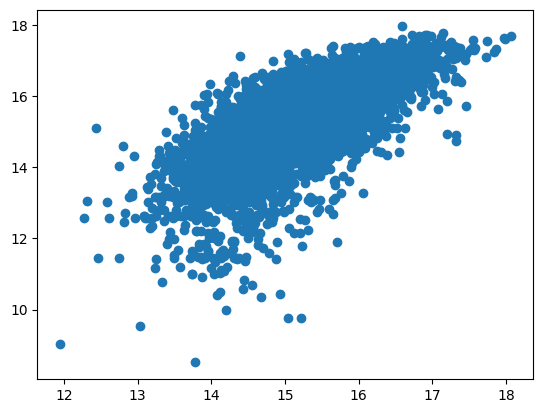

In [29]:
plt.scatter(pred, Y_valid)

CV

In [30]:
model = LinearRegression().fit(X, Y)

scores = cross_validate(model, X, Y, cv=5,
                        scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)
rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
r2 = scores['test_r2']
print(rmse, rmse.mean())
print(r2, r2.mean())

evaluation_kfold["Simple Linear Regression"] = [rmse.mean(), r2.mean()]
evaluation_kfold_all["Simple Linear Regression"] = [rmse, r2]

[1.03136883 0.86087793 0.79272893 0.90003131 1.10282024] 0.9375654484712603
[-0.04459255  0.3814865   0.4668532   0.48144442  0.37360531] 0.33175937766953784


# Model 2: SVM

In [31]:
model = SVR().fit(X_train, Y_train)
pred = model.predict(X_valid)

In [32]:
evaluation["SVM"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["SVM"])

[0.9132584243699482, 0.42459169184333734]


CV

In [33]:
model = SVR()

scores = cross_validate(model, X, Y, cv=5,
                        scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)
rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
r2 = scores['test_r2']
print(rmse, rmse.mean())
print(r2, r2.mean())

evaluation_kfold["SVM"] = [rmse.mean(), r2.mean()]
evaluation_kfold_all["SVM"] = [rmse, r2]

[1.11474553 0.84162238 0.83468188 0.9212082  1.06171234] 0.9547940660514517
[-0.22031062  0.40884607  0.40892939  0.45675509  0.419433  ] 0.2947305857647994


# Model 3: Decision Tree Regressor

In [34]:
parameters={"splitter":["best","random"],
            "max_depth" : [5,7,9,11],
           "min_samples_leaf":[5,10,25,50],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4],
           "max_features":["log2","sqrt"],
           "max_leaf_nodes":[10,20,30,40,50] }

In [35]:
model = DecisionTreeRegressor()
model = GridSearchCV(model, param_grid=parameters, scoring="neg_mean_squared_error", cv=5, verbose=3).fit(X_train, Y_train)
pred = model.predict(X_valid)

Streaming output truncated to the last 5000 lines.
[CV 1/5] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=50, min_weight_fraction_leaf=0.1, splitter=best;, score=-1.065 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=50, min_weight_fraction_leaf=0.1, splitter=best;, score=-1.098 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=50, min_weight_fraction_leaf=0.1, splitter=best;, score=-1.028 total time=   0.0s
[CV 4/5] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=50, min_weight_fraction_leaf=0.1, splitter=best;, score=-1.160 total time=   0.0s
[CV 5/5] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=50, min_weight_fraction_leaf=0.1, splitter=best;, score=-1.060 total time=   0.0s
[CV 1/5] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=50, min_weight_fraction_leaf=0.1, splitter=random;, s

In [36]:
evaluation["Decision Tree"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["Decision Tree"])

[1.0350104383565955, 0.2609425253295429]


In [37]:
scores = cross_validate(model, X, Y, cv=5,
                        scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)
rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
r2 = scores['test_r2']
print(rmse, rmse.mean())
print(r2, r2.mean())

evaluation_kfold["Decision Tree"] = [rmse.mean(), r2.mean()]
evaluation_kfold_all["Decision Tree"] = [rmse, r2]

Streaming output truncated to the last 5000 lines.
[CV 3/5] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=50, min_weight_fraction_leaf=0.1, splitter=best;, score=-1.044 total time=   0.0s
[CV 4/5] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=50, min_weight_fraction_leaf=0.1, splitter=best;, score=-0.790 total time=   0.0s
[CV 5/5] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=50, min_weight_fraction_leaf=0.1, splitter=best;, score=-1.034 total time=   0.0s
[CV 1/5] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=50, min_weight_fraction_leaf=0.1, splitter=random;, score=-1.414 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=50, min_weight_fraction_leaf=0.1, splitter=random;, score=-1.187 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=50, min_weight_fraction_leaf=0.1, splitter=random

# Model 4: Random Forest Regressor

In [38]:
model = RandomForestRegressor().fit(X_train, Y_train)
pred = model.predict(X_valid)

In [39]:
evaluation["Random Forest"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["Random Forest"])

[0.7839712015901004, 0.5759774306211035]


In [40]:
model = RandomForestRegressor()

scores = cross_validate(model, X, Y, cv=5,
                        scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)

rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
r2 = scores['test_r2']
print(rmse, rmse.mean())
print(r2, r2.mean())

evaluation_kfold["Random Forest"] = [rmse.mean(), r2.mean()]
evaluation_kfold_all["Random Forest"] = [rmse, r2]

[1.01182652 0.81736184 0.74719156 0.82720508 0.92171594] 0.865060187686642
[-0.00538183  0.44243598  0.5263459   0.56196737  0.56244484] 0.4175624505113217


# Model 5: Elastic Net Regressor

In [41]:
model = ElasticNet().fit(X_train, Y_train)
pred = model.predict(X_valid)

evaluation["Elastic Net"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["Elastic Net"])

[0.9170059658990285, 0.419859644962966]


In [42]:
evaluation["Elastic Net"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["Elastic Net"])

[0.9170059658990285, 0.419859644962966]


In [43]:
#model = ElasticNetCV(cv=5, random_state=0).fit(X, Y)
#pred = model.predict(X_valid)

In [44]:
#evaluation["Elastic Net"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
#print(evaluation["Elastic Net"])

In [45]:
model = ElasticNet()

scores = cross_validate(model, X, Y, cv=5,
                        scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)
rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
r2 = scores['test_r2']
print(rmse, rmse.mean())
print(r2, r2.mean())

evaluation_kfold["Elastic Net"] = [rmse.mean(), r2.mean()]
evaluation_kfold_all["Elastic Net"] = [rmse, r2]

[1.12105149 0.86873101 0.82706685 0.93203259 1.09613582] 0.9690035525604863
[-0.23415594  0.37015067  0.41966519  0.44391359  0.38117571] 0.27614984431801354


# Model 6: Histogram-based Gradient Boosting Regression Tree.

In [46]:
model = HistGradientBoostingRegressor().fit(X_train, Y_train)
pred = model.predict(X_valid)

In [47]:
evaluation["HistGradientBoostingRegressor"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["HistGradientBoostingRegressor"])

[0.7721384607749079, 0.5886806648332805]


In [48]:
model = HistGradientBoostingRegressor()

scores = cross_validate(model, X, Y, cv=5,
                        scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)
rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
r2 = scores['test_r2']
print(rmse, rmse.mean())
print(r2, r2.mean())

evaluation_kfold["HistGradientBoostingRegressor"] = [rmse.mean(), r2.mean()]
evaluation_kfold_all["HistGradientBoostingRegressor"] = [rmse, r2]

[1.01027529 0.79243383 0.7307049  0.83190217 0.88962199] 0.8509876342286542
[-0.00230149  0.47592668  0.5470175   0.55697872  0.5923855 ] 0.4340013813080727


# Model 7: Nerual Network

In [49]:
X_train.head(10)

,age,experience,g,mp,per,ts_percent_x,x3p_ar_x,f_tr_x,orb_percent_x,drb_percent,trb_percent,ast_percent,stl_percent,blk_percent,tov_percent_x,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp,All Star?,share,x1st_tm,x2nd_tm,x3rd_tm,fg_per_36_min,fga_per_36_min,fg_percent_x,x3p_per_36_min,x3pa_per_36_min,x3p_percent_x,x2p_per_36_min,x2pa_per_36_min,x2p_percent_x,ft_per_36_min,fta_per_36_min,ft_percent_x,orb_per_36_min,drb_per_36_min,trb_per_36_min,ast_per_36_min,stl_per_36_min,blk_per_36_min,tov_per_36_min,pf_per_36_min,pts_per_36_min,fg_per_100_poss,fga_per_100_poss,fg_percent_y,x3p_per_100_poss,x3pa_per_100_poss,...,ft_per_100_poss,fta_per_100_poss,ft_percent_y,orb_per_100_poss,drb_per_100_poss,trb_per_100_poss,ast_per_100_poss,stl_per_100_poss,blk_per_100_poss,tov_per_100_poss,pf_per_100_poss,pts_per_100_poss,o_rtg_x,d_rtg_x,dpoy_winner,mip_winner,nba mvp_share,nba mvp_winner,nba roy_winner,smoy_winner,playoffs,w,l,pw,pl,mov,sos,srs,o_rtg_y,d_rtg_y,n_rtg,pace,f_tr_y,x3p_ar_y,ts_percent_y,e_fg_percent,tov_percent_y,orb_percent_y,ft_fga,opp_e_fg_percent,opp_tov_percent,opp_drb_percent,opp_ft_fga,All-Rookie_1st,All-Rookie_2nd,All-Defense_1st,All-Defense_2nd,All-NBA_1st,All-NBA_2nd,All-NBA_3rd,pos_C,pos_PF,pos_PG,pos_SF,pos_SG
8251,32,10,77,2447,13.8,0.494,0.404,0.254,1.6,8.8,5.3,27.0,2.3,0.3,13.3,19.9,1.7,3.7,5.3,0.104,-0.3,1.1,0.8,1.8,0.0,0.000,0,0,0,4.6,12.1,0.385,1.6,4.9,0.338,3.0,7.2,0.417,2.3,3.1,0.750,0.5,2.9,3.3,6.0,1.6,0.1,2.1,2.0,13.2,6.8,17.7,0.385,2.4,7.1,...,3.4,4.5,0.750,0.7,4.2,4.9,8.8,2.3,0.2,3.0,2.9,19.4,105,104,0,0,0.000,0,0,0,0,39.789602,39.992104,39.883516,39.89819,-0.045182,0.000603,-0.044666,107.251618,107.284201,-0.032583,94.085095,0.295517,0.235626,0.540193,0.498689,13.571525,27.129949,0.223366,0.498738,13.564286,72.826581,0.223582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2345,32,11,82,3113,26.0,0.575,0.026,0.466,7.1,24.2,15.8,20.6,2.4,1.5,9.8,29.8,9.9,5.3,15.1,0.233,5.6,1.4,7.0,7.1,1.0,0.901,89,0,0,9.1,17.6,0.519,0.2,0.5,0.400,8.9,17.1,0.522,5.9,8.2,0.723,2.0,7.3,9.3,4.0,1.6,0.6,2.3,2.8,24.4,13.5,26.0,0.519,0.3,0.7,...,8.8,12.1,0.723,3.0,10.8,13.8,5.9,2.4,1.0,3.4,4.2,36.1,117,102,0,0,0.075,0,0,0,1,55.000000,27.000000,59.000000,23.00000,6.590000,-0.340000,6.250000,113.300000,106.100000,7.200000,90.000000,0.359000,0.158000,0.566000,0.517000,14.100000,31.600000,0.276000,0.489000,15.100000,71.700000,0.295000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4341,34,12,82,2751,14.8,0.501,0.210,0.301,4.2,9.6,6.9,15.4,1.6,2.2,12.2,24.8,1.6,3.9,5.4,0.095,0.5,0.4,0.9,2.0,0.0,0.000,0,0,0,6.6,15.5,0.422,1.2,3.3,0.361,5.4,12.3,0.439,3.3,4.7,0.709,1.4,3.0,4.4,3.1,1.1,1.1,2.4,3.4,17.6,9.4,22.2,0.422,1.7,4.7,...,4.7,6.7,0.709,2.0,4.3,6.3,4.4,1.6,1.5,3.5,4.8,25.2,99,100,0,0,0.000,0,0,0,1,51.000000,31.000000,48.000000,34.00000,2.210000,0.420000,2.630000,100.300000,98.000000,2.300000,93.100000,0.292000,0.156000,0.506000,0.460000,14.100000,27.300000,0.221000,0.460000,16.300000,73.700000,0.252000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7025,30,9,67,1523,8.9,0.511,0.000,0.312,8.1,21.8,14.9,5.4,0.6,3.2,20.7,10.8,0.1,1.0,1.1,0.035,-3.5,-0.1,-3.6,-0.6,0.0,0.000,0,0,0,2.9,6.0,0.490,0.0,0.0,0.000,2.9,6.0,0.490,1.1,1.9,0.582,2.5,6.6,9.1,1.4,0.4,1.5,1.8,4.6,6.9,4.2,8.6,0.490,0.0,0.0,...,1.6,2.7,0.582,3.6,9.5,13.1,2.0,0.6,2.2,2.6,6.7,10.0,99,110,0,0,0.000,0,0,0,0,28.000000,54.000000,29.000000,53.00000,-4.380000,-0.060000,-4.430000,107.000000,111.700000,-4.700000,92.300000,0.286000,0.219000,0.541000,0.504000,14.100000,27.600000,0.209000,0.522000,14.500000,68.100000,0.234000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10744,32,10,55,1278,15.6,0.531,0.114,0.293,7.3,12.0,9.6,11.7,3.8,1.2,16.2,20.1,0.5,2.1,2.7,0.100,-1.1,2.1,1.0,1.0,0.0,0.000,0,0,0,5.7,11.6,0.494,0.3,1.3,0.234,5.4,10.3,0.527,2.1,3.4,0.628,2.2,3.6,5.9,2.6,2.5,0.5,2.5,3.4,13.9,8.5,17.3,0.494,0.5,2.0,...,3.2,5.1,0.628,3.3,5.4,8.7,3.9,3.8,0.8,3.8,5.1,20.7,102,101,0,0,0.000,0,0,0,1,50.000000,32.000000,46.000000,36.00000,1.570000,0.610000,2.180000,106.300000,104

In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

NN = Sequential()
NN.add(Dense(50, input_dim=114, kernel_initializer="normal", activation="relu", name="hidden1"))
NN.add(Dense(25, input_dim=114, kernel_initializer="normal", activation="relu", name="hidden2"))
NN.add(Dense(1, kernel_initializer="normal", activation="relu", name="output"))
NN.summary()

# Put your statements here

NN.compile(loss="mean_squared_error", optimizer="Adam", metrics=["mean_squared_error"])
NN.fit(x=X_train, y=Y_train, batch_size=32, epochs=500)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 50)                5750      
                                                                 
 hidden2 (Dense)             (None, 25)                1275      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 7051 (27.54 KB)
Trainable params: 7051 (27.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
343/343 [==============================] - 2s 2ms/step - loss: 3.8577 - mean_squared_error: 3.8577
Epoch 2/500
343/343 [==============================] - 1s 2ms/step - loss: 0.8983 - mean_squared_error: 0.8983
Epoch 3/500
343/343 [==============================] - 1s 2ms/st

In [51]:
nn_pred = NN.predict(X_valid)
print(nn_pred)

nn_r2 = r2_score(y_true=Y_valid, y_pred=nn_pred)

147/147 [==============================] - 0s 2ms/step
[[14.339975 ]
 [15.423024 ]
 [15.202004 ]
 ...
 [15.798003 ]
 [14.7555065]
 [14.0700655]]


In [52]:
print(r2_score(y_true=Y_valid, y_pred=nn_pred))

0.5336595090791687


In [53]:
result = NN.evaluate(X_valid, Y_valid, batch_size=32)
print(np.sqrt(result[1]))

147/147 [==============================] - 0s 2ms/step - loss: 0.6759 - mean_squared_error: 0.6759
0.8221615976960583


# Results

In [54]:
evaluation["Neural Network"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=nn_pred)), nn_r2]

In [55]:
evaluation_df = pd.DataFrame(evaluation, index = ["RMSE", "R^2"]).T
evaluation_df

,RMSE,R^2
Simple Linear Regression,0.846049,0.506168
SVM,0.913258,0.424592
Decision Tree,1.035010,0.260943
Random Forest,0.783971,0.575977
Elastic Net,0.917006,0.419860
HistGradientBoostingRegressor,0.772138,0.588681
Neural Network,0.822162,0.533660


In [56]:
evaluation_kfold_df = pd.DataFrame(evaluation_kfold, index = ["RMSE", "R^2"]).T
evaluation_kfold_df

,RMSE,R^2
Simple Linear Regression,0.937565,0.331759
SVM,0.954794,0.294731
Decision Tree,1.077193,0.118179
Random Forest,0.865060,0.417562
Elastic Net,0.969004,0.276150
HistGradientBoostingRegressor,0.850988,0.434001


In [57]:
evaluation_kfold_all_df = pd.DataFrame(evaluation_kfold_all, index = ["RMSE", "R^2"]).T
evaluation_kfold_all_df

,RMSE,R^2
Simple Linear Regression,"[1.0313688337717153, 0.8608779344096116, 0.792...","[-0.04459254653086964, 0.3814865039621783, 0.4..."
SVM,"[1.1147455254484517, 0.841622381570506, 0.8346...","[-0.22031062053944006, 0.40884607103129555, 0...."
Decision Tree,"[1.1609282283492708, 0.9917400128131778, 0.981...","[-0.3235174087558774, 0.1791539756847973, 0.18..."
Random Forest,"[1.011826520225251, 0.8173618368359363, 0.7471...","[-0.005381829434204954, 0.4424359802810086, 0...."
Elastic Net,"[1.1210514918019847, 0.8687310058060284, 0.827...","[-0.23415593860192274, 0.37015066950518294, 0...."
HistGradientBoostingRegressor,"[1.0102752874767538, 0.7924338340607329, 0.730...","[-0.0023014877169933445, 0.47592668353980294, ..."


In [88]:
eval_kfold_all_ignore1 = [{"RMSE": np.array(evaluation_kfold_all[s][0][1:5]).mean(), "R^2": np.array(evaluation_kfold_all[s][1][1:5]).mean()} for s in evaluation_kfold_all]

eval_kfold_all_ignore1_df = pd.DataFrame(eval_kfold_all_ignore1)
eval_kfold_all_ignore1_df

,RMSE,R^2
0,0.914115,0.425847
1,0.914806,0.423491
2,1.056259,0.228603
3,0.828369,0.523299
4,0.930992,0.403726
5,0.811166,0.543077


# 5-fold on NN (May take very long time!!)

In [61]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)
fold = 1
nnRMSE = []
nn_r2_list = []
for train, test in kfold.split(X, Y):

  NN = Sequential()
  NN.add(Dense(50, input_dim=114, kernel_initializer="normal", activation="relu", name="hidden1"))
  NN.add(Dense(25, input_dim=114, kernel_initializer="normal", activation="relu", name="hidden2"))
  NN.add(Dense(1, kernel_initializer="normal", activation="relu", name="output"))

  NN.compile(loss="mean_squared_error", optimizer="Adam", metrics=["mean_squared_error"])

  his = NN.fit(X.iloc[train], Y.iloc[train], batch_size=32, epochs=500)

  nn_pred = NN.predict(X.iloc[test])
  nn_r2 = r2_score(y_true=Y.iloc[test], y_pred=nn_pred)
  print(f'Fold {fold}: {nn_r2}')
  nn_r2_list.append(nn_r2)


  foldRMSE = np.sqrt(NN.evaluate(X.iloc[test], Y.iloc[test], batch_size=32)[1])
  print(f'Fold {fold}: {foldRMSE}')
  nnRMSE.append(foldRMSE)

  # Increase fold number
  fold = fold + 1

print(nnRMSE)
print("Average RMSE: ", np.array(nnRMSE).mean())
print(nn_r2_list)
print("Average RMSE: ", np.array(nn_r2_list).mean())

Streaming output truncated to the last 5000 lines.
391/391 [==============================] - 1s 2ms/step - loss: 0.7875 - mean_squared_error: 0.7875
Epoch 12/500
391/391 [==============================] - 1s 2ms/step - loss: 0.7757 - mean_squared_error: 0.7757
Epoch 13/500
391/391 [==============================] - 1s 3ms/step - loss: 0.7505 - mean_squared_error: 0.7505
Epoch 14/500
391/391 [==============================] - 1s 3ms/step - loss: 0.7828 - mean_squared_error: 0.7828
Epoch 15/500
391/391 [==============================] - 1s 3ms/step - loss: 0.7549 - mean_squared_error: 0.7549
Epoch 16/500
391/391 [==============================] - 1s 2ms/step - loss: 0.7339 - mean_squared_error: 0.7339
Epoch 17/500
391/391 [==============================] - 1s 2ms/step - loss: 0.7468 - mean_squared_error: 0.7468
Epoch 18/500
391/391 [==============================] - 1s 2ms/step - loss: 0.7502 - mean_squared_error: 0.7502
Epoch 19/500
391/391 [==============================] - 1s 2ms/ste

AttributeError: ignored

In [68]:
np.array(nnRMSE[0:4]).mean()

0.8131388488215241

In [70]:
np.array(nn_r2_list[0:4]).mean()

0.5466639892110483